In [1]:
import pandas as pd
import numpy as np

def create_df_response(samples, time,  quantiles = [50, 80, 95], forecast_horizon=27, date_init=None, sample_freq="D", dates=None, use_future=False):
    """ Create a dataframe with the quantiles of the model and forecast if provided

    Args:
        samples    : Samples of the variable to create the dataframe. It should be a 2D array with shape (n_time, n_samples)
        time (int) : n_time
        date_init (str, optional):        [description]. Defaults to '2020-03-06'.
        forecast_horizon (int, optional): [description]. Defaults to 27.
        use_future (bool, optional):      [description]. Defaults to False.

    Returns:
        df_response: Dataframe with the quantiles of the model, mean, median and std.
    """

    if samples.shape[0] != time:
        raise Exception("Samples first dimension must be equal to time")

    if dates is not None:
        dates_fitted = dates
    elif date_init is not None and sample_freq is not None:
        dates_fitted = pd.date_range(pd.to_datetime(date_init), periods=time, freq=sample_freq)
    else:
        dates_fitted   = list(range(time))
        dates_forecast = list(range(time, time+forecast_horizon))

    dates = dates_fitted
    types = ['estimate']*len(dates_fitted)

    if use_future:
        dates += list(dates_forecast)
        types += ['forecast']*len(dates_forecast)

    results_df  = pd.DataFrame(samples)
    df_response = pd.DataFrame(index=dates)

    # Calculate key statistics
    df_response['mean']   = results_df.mean(axis=1).values
    df_response['median'] = results_df.median(axis=1).values
    df_response['std']    = results_df.std(axis=1).values

    for quant in quantiles:
        low_q                        = ((100-quant)/2)/100
        high_q                       = 1-low_q
        df_response[f'low_{quant}']  = results_df.quantile(q=low_q, axis=1).values
        df_response[f'high_{quant}'] = results_df.quantile(q=high_q, axis=1).values

    df_response['type']    =  types
    df_response.index.name = 'date'

    return df_response

In [2]:


class Agent:
    S = 0
    I = 1
    R = 2

class gen:
    A: 0
    C: 1
    G: 2
    T: 3


# def genetic(agents_genetic, μ_genetic):
#     agents_genetic = agents_genetic.copy()
#     return agents_genetic

def sir_abm(agents_state, beta, gamma, N, model_settings):
    """ Agent based model tracking colonized and susceptible patients with pre-defined movement patterns.

    Args:
        agents_state : agent state. {0: Patient.susceptible, 1: Patient.colonized}  Size: (n_patients)
        movement     : pd.Dataframe with patient locations and culture information.
        parameters   : dictionary of parameters, contains importation rate (gamma), nosocomial transmission rate (beta),
                        effective sensitivity (ro), and decolonization rate (alpha)
    """

    n  = model_settings["n"] # number of patients
    m  = model_settings["m"] # number of ensembles

    p_update = agents_state.copy()
    λ        = beta * np.sum(p_update == Agent.I, axis=0) / N

    Pr   = np.random.random(size=(n, m)) <= gamma
    Pinf = np.random.random(size=(n, m)) <= λ

    p_update = p_update + Agent.R * ( (agents_state==Agent.I) * Pr)   # Infected to recovered
    p_update = p_update + Agent.I * ( (agents_state==Agent.S) * Pinf) # Susceptible to infected

    p_update = np.clip(p_update, 0, 2)

    return p_update

n = 1000 # n agents
m = 100  # m samples/ensembles

agents_state = np.zeros((n, m)) + Agent.I * (np.random.random(size=(n, m)) <= 30/100)
T            = 100

s = np.full((T, m), np.nan); s[0, :] = np.sum(agents_state==Agent.S, axis=0)
i = np.full((T, m), np.nan); i[0, :] = np.sum(agents_state==Agent.I, axis=0)
r = np.full((T, m), np.nan); r[0, :] = np.sum(agents_state==Agent.R, axis=0)

for t in range(1, T):
    agents_state = sir_abm(agents_state, beta=0.5, gamma=1/7, N=n, model_settings={"n": n, "m": m})

    s[t, :] = np.sum(agents_state==Agent.S, axis=0)
    i[t, :] = np.sum(agents_state==Agent.I, axis=0)
    r[t, :] = np.sum(agents_state==Agent.R, axis=0)


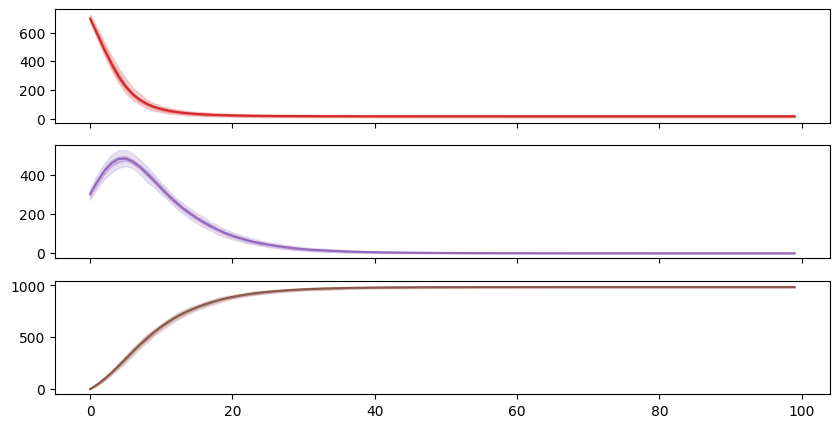

In [3]:
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, "../")
sys.path.insert(0,"../pompjax/pompjax/")

from utils import create_df_response

colors = ["#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

fig, ax = plt.subplots(3, 1, figsize=(10, 5), sharex=True, sharey=False)

S_df = create_df_response(s, time=T)
I_df = create_df_response(i, time=T)
R_df = create_df_response(r, time=T)

ax[0].plot(range(T), S_df["mean"], label="S", color=colors[0])
ax[0].fill_between(range(T), S_df["low_95"], S_df["high_95"], alpha=0.2, color=colors[0])
ax[0].fill_between(range(T), S_df["low_50"], S_df["high_50"], alpha=0.3, color=colors[0])

ax[1].plot(range(T), I_df["mean"], label="I", color=colors[1])
ax[1].fill_between(range(T), I_df["low_95"], I_df["high_95"], alpha=0.2, color=colors[1])
ax[1].fill_between(range(T), I_df["low_50"], I_df["high_50"], alpha=0.3, color=colors[1])

ax[2].plot(range(T), R_df["mean"], label="R", color=colors[2])
ax[2].fill_between(range(T), R_df["low_95"], R_df["high_95"], alpha=0.2, color=colors[2])
ax[2].fill_between(range(T), R_df["low_50"], R_df["high_50"], alpha=0.3, color=colors[2])

